#SENTIMENT ANALYSIS


##1.Naive Bayes Classifier

In [ ]:
# Tập dữ liệu ví dụ

train_x = [
           'just plain boring',
           'entirely predictable and lacks energy',
           'no surprises and very few laughs',
           'very powerful',
           'the most fun film of the summer'
]
train_y = [0, 0, 0, 1, 1]

###1.1. Tiền xử lý dữ liệu cơ bản

In [ ]:
def basic_preprocess(text):
    """ Tiền xử lý và tách các câu
    Args:
        text: câu đầu vào. 
        VD: "Tôi đi học"
    Output:
        text_clean: danh sách các từ (token) sau khi chuyển sang chữ thường và
            được phân tách bởi khoảng trắng
    """
    text_clean = text.lower()
    return text_clean.split()

basic_preprocess(train_x[0])

['just', 'plain', 'boring']

###1.2.Xây dựng bộ từ điển

In [ ]:
# Ex 1
def count_freq_words(corpus, labels):
    """ Xây dựng bộ từ điển tần suất xuất hiện của các từ
    Args:
        corpus: tập danh sách các câu
        labels: tập nhãn tương ứng với các câu trong corpus (0 hoặc 1)
    Output:
        model: bộ từ điển ánh xạ mỗi từ và tần suất xuất hiện của từ đó trong corpus
            key: (word, label)
            value: frequency
            VD: {('boring', 0): 2} => từ boring xuất hiện 2 lần trong các sample thuộc class 0
    """
    model = {}
    for label, sentence in zip(labels, corpus):
        for word in basic_preprocess(sentence):
            # Định nghĩa key của model là tuple (word, label)
            pair = (word, label)
            # Nếu key đã tồn tại trong model thì tăng value lên 1
            if pair in model:
                model[pair] += 1
            # Nếu key chưa tồn tại trong model thì bổ sung key vào model với value =1
            else:
                model[pair] = 1
    return model

In [ ]:
#Kết quả mong đợi
freqs = count_freq_words(train_x, train_y)
freqs

{('just', 0): 1,
 ('plain', 0): 1,
 ('boring', 0): 1,
 ('entirely', 0): 1,
 ('predictable', 0): 1,
 ('and', 0): 2,
 ('lacks', 0): 1,
 ('energy', 0): 1,
 ('no', 0): 1,
 ('surprises', 0): 1,
 ('very', 0): 1,
 ('few', 0): 1,
 ('laughs', 0): 1,
 ('very', 1): 1,
 ('powerful', 1): 1,
 ('the', 1): 2,
 ('most', 1): 1,
 ('fun', 1): 1,
 ('film', 1): 1,
 ('of', 1): 1,
 ('summer', 1): 1}

In [ ]:
# Hàm lấy ra tần suất xuất hiện là value trong `freq` dựa vào key (word, label)
def lookup(freqs, word, label):
    '''
    Args:
        freqs: a dictionary with the frequency of each pair
        word: the word to look up
        label: the label corresponding to the word
    Output:
        count: the number of times the word with its corresponding label appears.
    '''
    count = 0

    pair = (word, label)
    if pair in freqs:
        count = freqs[pair]

    return count

lookup(freqs, "just", 0)

1

###1.3.Thuật toán phân loại Naive Bayes
**Bước 1: Tính xác suất tiên nghiệm của các class**
- Tính $D$, $D_{pos}$, $D_{neg}$
    - Dựa vào `train_y` tính số lượng các sample có trong tập training: $D$, số lượng các sample là positive (nhãn 1): $D_{pos}$ và số lượng nhãn là negative (nhãn 0): $D_{neg}$
    - Tính xác suất tiên nghiệm của class 1 là: $P(D_{pos})=D_{pos}/D$, và class 0 là: $P(D_{pos})=D_{pos}/D$

In [ ]:
# Ex 2
def compute_prior_prob(train_y):
    # Tính D, D_pos, D_neg dựa vào x_train
    # Tính D, số lượng các sample trong training
    D = len(train_y)

    # Tính D_pos, số lượng các positive sample trong training
    D_pos = len(list(filter(lambda x: x == 1, train_y)))
    print(D_pos)
    # Tính D_neg, số lượng các negative sample trong training
    D_neg = len(list(filter(lambda x: x == 0, train_y)))
    print(D_neg)
    # Tính xác suất tiên nghiệm cho các class 0 và 1
    p_prior = {0:(D_neg/D), 1:(D_pos/D)}
    return p_prior

In [ ]:
# Kết quả mong đợi
compute_prior_prob(train_y)

2
3


{0: 0.6, 1: 0.4}

**Bước 2: Tính xác suất likelihood**
- Tính $V$: Dựa vào `freqs` tính số lượng các từ duy nhất (uniqe words) - gọi là bộ từ điển

- Tính $N_{pos}$ và $N_{neg}$: Dựa vào `freqs` dictionary, tính tổng số từ (có thể trùng lặp) xuất hiện trong positive samples $N_{pos}$ và negative samples $N_{neg}$.

- Tính tần suất xuất hiện của mỗi từ trong positive samples $freq_{pos}$ và trong negative samples $freq_{neg}$

- Tính xác suất likelihood mỗi từ trong bộ từ điển
    - Sử dụng hàm `lookup` lấy ra tần suất xuất hiện của từ là positive $freq_{pos}$, và tần xuất xuất hiện của từ là negative $freq_{neg}$
- Tính xác suất cho mỗi từ thuộc vào positive sample: $P(W_{pos})$, thuộc vào negative sample $P(W_{neg})$ sử dụng công thức 4 & 5.

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

**Note:** Chúng ta lưu trữ likelihood của mỗi từ vào dictionary với key (từ): $W$, value (dictionary): ${0: P(W_{pos}), 1: P(W_{pos})}$

In [ ]:
# Ex 3
def compute_likelihood(freqs):
    # Tính xác suất likelihood của mỗi từ trong bộ từ điển

    # Tính V các từ duy nhất xuất hiện trong tập train
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # Tính N_pos: số lượng từ trong positive samples và N_neg: số từ trong negative sample
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # Nếu như class: 1 tăng N_pos thêm số lần xuất hiện của pair trong freqs
        if pair[1] > 0:
            N_pos += freqs[pair]

        # Nếu như class: 0 tăng N_neg thêm số lần xuất hiện của pair trong freqs
        else:
            N_neg += freqs[pair]
    
    print(f'V: {V}, N_pos: {N_pos}, N_neg: {N_neg}')

    # Tính likelihood cho mỗi từ trong bộ từ điển
    p_likelihood = {}
    for word in vocab:
        # Lấy tần xuất xuất hiện của mỗi từ là positive hoặc negative
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        # Tính xác suất likelihood của mỗi từ với class positive và negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # Lưu vào p_likelihood dictionary
        p_likelihood[word] = {0:p_w_neg, 1:p_w_pos}
    
    return p_likelihood

In [ ]:
# Kết quả mong đợi
compute_likelihood(freqs)

V: 20, N_pos: 9, N_neg: 14


{'energy': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'fun': {0: 0.029411764705882353, 1: 0.06896551724137931},
 'lacks': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'plain': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'of': {0: 0.029411764705882353, 1: 0.06896551724137931},
 'boring': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'surprises': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'very': {0: 0.058823529411764705, 1: 0.06896551724137931},
 'film': {0: 0.029411764705882353, 1: 0.06896551724137931},
 'powerful': {0: 0.029411764705882353, 1: 0.06896551724137931},
 'predictable': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'no': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'summer': {0: 0.029411764705882353, 1: 0.06896551724137931},
 'just': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'and': {0: 0.08823529411764706, 1: 0.034482758620689655},
 'entirely': {0: 0.058823529411764705, 1: 0.034482758620689655},
 'few': {

**Bước 3: Hoàn thiện `train` function cho Naive Bayes***

In [ ]:
def train_naive_bayes(train_x, train_y):
    ''' Huấn luyện thuật toán Naive Bayes
    Args:
        train_x: Danh sách các câu
        train_y: Danh sách các nhãn tương ứng (0 hoặc 1)
    Output:
        p_prior: the prior probability (Xác suấ tiên nghiệm)
        p_likelihood: the maximum likelihood of the probability.
    '''
    # Xây dựng từ điển tần suất xuất hiện của từ và nhãn tương ứng
    freqs = count_freq_words(train_x, train_y)

    # Tính xác suất tiên nghiệm
    p_prior = compute_prior_prob(train_y)

    # Tính xác suất likelihood
    p_likelihood = compute_likelihood(freqs)

    return p_prior, p_likelihood

In [ ]:
# Kết quả đầu ra thu được khi huấn luận Naive Bayes Classifier
p_prior, p_likelihood = train_naive_bayes(train_x, train_y)
p_prior, p_likelihood

2
3
V: 20, N_pos: 9, N_neg: 14


({0: 0.6, 1: 0.4},
 {'energy': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'fun': {0: 0.029411764705882353, 1: 0.06896551724137931},
  'lacks': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'plain': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'of': {0: 0.029411764705882353, 1: 0.06896551724137931},
  'boring': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'surprises': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'very': {0: 0.058823529411764705, 1: 0.06896551724137931},
  'film': {0: 0.029411764705882353, 1: 0.06896551724137931},
  'powerful': {0: 0.029411764705882353, 1: 0.06896551724137931},
  'predictable': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'no': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'summer': {0: 0.029411764705882353, 1: 0.06896551724137931},
  'just': {0: 0.058823529411764705, 1: 0.034482758620689655},
  'and': {0: 0.08823529411764706, 1: 0.034482758620689655},
  'entirely': {0: 0.058823529411764705, 

###1.4.Dự đoán với các mẫu thử nghiệm
- Tính xác suất của mỗi sample (n từ) dựa vào công thức:
$$P(0).P(S|0) = P(0).P(w_{1}|0).P(w_{2}|0)...P(w_{n}|0)$$ 

In [ ]:
# Ex 4
def naive_bayes_predict(sentence, p_prior, p_likelihood):
    '''
    Args:
        sentence: a string
        p_prior: a dictionary of the prior probability
        p_likelihood: a dictionary of words mapping to the probability
    Output:
        p: the probability of sentence with 0: negative, 1: positive

    '''
    # Tiền xử lý dữ liệu
    words = basic_preprocess(sentence)

    # Khởi tạo giá trị xác suất ban đầu là giá trị xác suất tiên nghiệm
    p_neg = p_prior[0]
    p_pos = p_prior[1]
    
    for word in words:
        # Kiểm tra xem word có tồn tại trong p_likelihood hay không
        if word in p_likelihood:
            # nhân xác suất tiên nghiệm với xác suất likelihood của các từ
            p_neg *= p_likelihood[word][0]
            p_pos *= p_likelihood[word][1]
   
    return {'prob': {0: p_neg, 1: p_pos},
            'label': 0 if p_neg > p_pos else 1}

In [ ]:
# Kết quả mong đợi
sentence = "predictable with no fun"
naive_bayes_predict(sentence, p_prior, p_likelihood)

{'prob': {0: 6.106248727864848e-05, 1: 3.2801672885317154e-05}, 'label': 0}

##2.Naive Bayes Classfier for Sentiment Analysis on Tweets
**Phân tích cảm xúc trên tập 1Tweets1 sử dụng thuật toán phân loại Naive Bayes**

In [ ]:
import re
import string
import nltk
import numpy as np
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


###2.1.Dowload Dataset

In [ ]:
# Tải về tập dữ liệu tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Chia thành 2 tập train và test
# train: 4000 samples, test: 1000 samples
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]

train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# Tạo nhãn negative: 0, positive: 1
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

In [ ]:
all_positive_tweets[:10]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing 

In [ ]:
all_negative_tweets[:10]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(',
 "oh god, my babies' faces :( https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search :( http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan:( https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948 :-( #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz']

###2.2.Tiền xử lý dữ liệu cho tập `Tweets`

Dựa vào việc quan sát tập dữ liệu trên chúng ta tiến hàng một số bước tiền xử lý như sau:
- Xóa bỏ các hashtags như #FollowFriday,...
- Xóa bỏ các thẻ gắn nhãn các tài khoản như: @Lamb2ja
- Xóa bỏ các thẻ HTML, CSS,.. có thể có như: https://t.co/smyYriipxI
- Xóa bỏ retweet trong text: "RT"
- Xóa bỏ dấu câu và có thể xóa hết số, ký tự đặc biệt (Với mục đích tập trung ngữ nghĩa các từ)
- Có thể thực hiện một số bước tiền xử lý khác
- Sau khi tiền xử lý xong chúng ta tiến hành tách câu thành các từ (word base tokenizer). Ở đây chúng ta sẽ dùng bộ tách từ có sẵn cho tách từ `tweet` của nltk là `TweetTokenizer`

In [ ]:
# Ex 5
def basic_preprocess(text):
    '''
    Args:
        text: câu đầu vào
    Output:
        text_clean: danh sách các từ (token) sau khi chuyển sang chữ thường và
            được phân tách bởi khoảng trắng
    '''
    # xóa bỏ stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)

    # xóa bỏ old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)

    # xóa bỏ hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # xóa bỏ hashtags
    text = re.sub(r'#', '', text)

    # tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if word not in string.punctuation:  # remove punctuation
            text_clean.append(word)

    return text_clean

In [ ]:

example_sentence = "RT @Twitter @chapagain Hello There! Have a great day. #good #morning http://chapagain.com.np"
basic_preprocess(example_sentence)

['hello', 'there', 'have', 'a', 'great', 'day', 'good', 'morning']

###2.3.Huấn luyện Naive Bayes Classifier trên tập `Tweets`

In [ ]:
p_prior, p_likelihood = train_naive_bayes(train_x, train_y)

4000
4000
V: 10841, N_pos: 41916, N_neg: 43321


In [ ]:
#Kết quả ví dụ về xác suất tiên nghiệm và likelihood của từ happy
p_prior, p_likelihood['boring']

({0: 0.5, 1: 0.5}, {0: 5.538938739337543e-05, 1: 9.477415319294123e-05})

###2.4.Dự đoán

In [ ]:
test_x[0], test_y[0]

('Bro:U wan cut hair anot,ur hair long Liao bo\nMe:since ord liao,take it easy lor treat as save $ leave it longer :)\nBro:LOL Sibei xialan',
 1.0)

In [ ]:
naive_bayes_predict(test_x[0], p_prior, p_likelihood)

{'prob': {0: 1.1032955242760357e-80, 1: 2.0993946427583525e-79}, 'label': 1}

###2.5.Đánh giá độ chính xác trên tập test

In [ ]:
acc = 0
for sentence, label in zip(test_x, test_y):
    # predic each sentence in test set
    pred = naive_bayes_predict(sentence, p_prior, p_likelihood)['label']

    # compare predict label with target label
    if int(pred) == int(label):
        acc += 1

print('Accuracy: ', acc/len(test_x))

Accuracy:  0.994


In [ ]:
sent = 'i very boring'
naive_bayes_predict(sent, p_prior, p_likelihood)

{'prob': {0: 7.813837845893465e-10, 1: 9.566965848216719e-10}, 'label': 1}

##3.Logistic Regression for Sentiment Analysis on Tweets

###3.1.Download Dataset
Tương tự như mục 2.1

In [ ]:
# Tải về tập dữ liệu tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Chia thành 2 tập train và test
# train: 4000 samples, test: 1000 samples
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]

train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# Tạo nhãn negative: 0, positive: 1
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

###3.2. Tiền xử lý dữ liệu cho tập Tweets

In [ ]:
# Ex 6
def basic_preprocess(text):
    '''
    Args:
        text: câu đầu vào
    Output:
        text_clean: danh sách các từ (token) sau khi chuyển sang chữ thường và
            được phân tách bởi khoảng trắng
    '''
    # xóa bỏ stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)

    # xóa bỏ old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)

    # xóa bỏ hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # xóa bỏ hashtags
    text = re.sub(r'#', '', text)

    # tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if word not in string.punctuation:  # remove punctuation
            text_clean.append(word)
    return text_clean

In [ ]:
# Kết quả đầu ra
example_sentence = "RT @Twitter @chapagain Hello There! Have a great day. #good #morning http://chapagain.com.np"
basic_preprocess(example_sentence)

['hello', 'there', 'have', 'a', 'great', 'day', 'good', 'morning']

###3.3.Logistic Regression

####Sigmoid
The sigmoid function: 

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$


In [ ]:
# Ex 7
def sigmoid(z): 
    '''
    Args:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    ### START CODE HERE
    # calculate the sigmoid of z
    h = 1 / (1 + np.exp(-z))
    
    return h

In [ ]:
# Kết quả kiểm tra hàm sigmpoid
sigmoid(0) == 0.5, sigmoid(4.92) == 0.9927537604041685

(True, True)

#### Gradient Descent Function
* Số vòng lặp huấn luyện mô hình: `num_iters`
* Với mỗi vòng lặp chúng ta sẽ tính `logits-z`, cost và cập nhật trọng số
* Số samples training: `m`, số features trên mỗi sample: `n`
* Trọng số mô hình:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$

* Tính `logits-z`:   $$z = \mathbf{x}\mathbf{\theta}$$
    * $\mathbf{x}$ có chiều (m, n+1) 
    * $\mathbf{\theta}$: có chiều (n+1, 1)
    * $\mathbf{z}$: có chiều (m, 1)
* Dự đoán 'y_hat' có chiều (m,1):$$\widehat{y}(z) = sigmoid(z)$$
* Cost function $J$:
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\widehat{y}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-\widehat{y}}) \right)$$
* Cập nhật `theta`:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{\widehat{y}-y} \right) \right)$$

In [ ]:
# Ex 8
def gradient_descent(x, y, theta, alpha, num_iters):
    '''
    Args:
        x: matrix of features, có chiều (m,n+1)
        y: label tương ứng (m,1)
        theta: vector trọng số (n+1,1)
        alpha: tốc độ học
        num_iters: số vòng lặp
    Output:
        J: final cost
        theta: vector trọng số
    '''

    # lấy m số lượng các sample trong matrix x
    loss = []
    m = len(x)
    
    for i in tqdm(range(num_iters)):
        
        # Tính z, phép dot product: x và theta
        z = np.dot(x, theta)
        
        # Tính h: sigmoid của z
        y_hat = sigmoid(z)
        
        # Tính cost function
        J = (-1 / m) * (np.dot(y.T, np.log(y_hat)) + np.dot((1 - y).T, np.log(1 - y_hat)))
        loss.append(J[0][0])
        # Cập nhật trọn số theta
        theta = theta - (alpha / m) * (np.dot(x.T, (y_hat - y)))
  
    return J, theta, loss

In [ ]:
# print(J)

In [ ]:
# Kiểm qua kết quả
np.random.seed(1)

# X input: 10 x 3, bias là 1
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)

# Y label: 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.5).astype(float)

# Apply gradient descent
tmp_J, tmp_theta, loss = gradient_descent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 1000)
print(f"\nCost {tmp_J.item()}")
print(f"Weight {tmp_theta}")

100%|██████████| 1000/1000 [00:00<00:00, 43081.69it/s]


Cost 0.6664917318262262
Weight [[5.25489588e-07]
 [4.66089993e-04]
 [3.61985668e-05]]


###3.4.Trích xuất các feature
Chuyển từ `tweet` sang feature
Với mỗi `tweet` sẽ được biểu diễn bởi 2 feature (Dựa vào `freq` tương tự ở mục #1 và #2):
- số lượng các positive words
- số lượng các negative words

In [ ]:
# Ex 9
def extract_features(text, freqs):
    '''
    Args: 
        text: tweet
        freqs: bộ từ điển tần suất xuất hiện của từ theo label (word, label)
    Output: 
        x: vector feature có chiều (1,3)
    '''
    # tiền xử lý
    word_l = basic_preprocess(text)
    
    # 3 thành phần: bias, feature 1 và feature 2
    x = np.zeros((1, 3)) 
    
    # bias
    x[0,0] = 1 
    
    ### START CODE HERE
    for word in word_l:
        x[0,1] += lookup(freqs, word, 1)
        
        x[0,2] += lookup(freqs, word, 0)
        
    assert(x.shape == (1, 3))
    return x

In [ ]:
# Kiểm tra
# freqs tương tự mục 1.2
freqs = count_freq_words(train_x, train_y)
print(train_x[0])
extract_features(train_x[0], freqs)

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


array([[1.000e+00, 4.722e+03, 1.612e+03]])

In [ ]:
# Kiểm tra
# freqs tương tự mục 1.2
# VD: các từ không có trong bộ `freq`
x_test = "việt nam"
extract_features(x_test, freqs)

array([[1., 0., 0.]])

###3.5.Huấn luyện mô hình Logistic Regression

In [ ]:
# Tạo ma trận X có kích thước mxn với n=3 (số features)
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = np.expand_dims(train_y, 1)

# Huấn luyện với số vòng lặp 1500, tốc độ học 1e-6
J, theta, loss = gradient_descent(X, Y, np.zeros((3, 1)), 1e-9, 3000)
print(f"Cost {J.item()}.")
print(f"Weight {theta}")


100%|██████████| 3000/3000 [00:02<00:00, 1398.31it/s]

Cost 0.17134489822155838.
Weight [[ 1.04365193e-07]
 [ 8.07635531e-04]
 [-6.93031654e-04]]


In [ ]:
import matplotlib.pyplot as plt


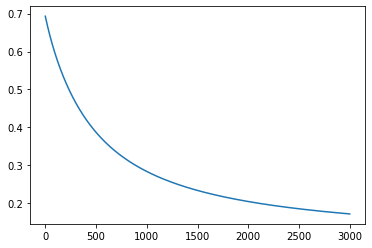

In [ ]:
plt.plot(loss)
plt.show()

###3.6.Dự đoán
* Tiền xử lý với dữ liệu thử nghiệm
* Tính `logits` dựa vào công thức

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [ ]:
# Ex 10
def predict_tweet(text, freqs, theta):
    '''
    Args: 
        text: tweet
        freqs: bộ từ điển tần suất xuất hiện của từ theo label (word, label)
        theta: (3,1) vector trọng số
    Output: 
        y_pred: xác suất dự đoán
    '''
    
    # extract features
    x = extract_features(text, freqs)
    
    # dự đoán
    y_pred = sigmoid(np.dot(x, theta))
    
    
    return y_pred

In [ ]:
tests = ["happy", "sad"]
for t in tests:
    pred = predict_tweet(t, freqs, theta)
    print(f'{t} -> {pred}')

happy -> [[0.52693969]]
sad -> [[0.48348788]]


###3.7.Đánh giá độ chính xác trên tập test

In [ ]:
acc = 0
for sentence, label in zip(test_x, test_y):

    # predic each sentence in test set
    pred = predict_tweet(sentence, freqs, theta)
    if pred > 0.5:
        pred_l = 1
    else:
        pred_l = 0

    # compare predict label with target label
    if int(pred_l) == int(label):
        acc += 1

print('Accuracy: ', acc/len(test_x))

Accuracy:  0.9705


In [ ]:
sentence = "teacher is boring"
pred = predict_tweet(sentence, freqs, theta)
print(pred)

[[0.50664692]]
